/Users/Hatim/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: FutureWarning: The pandas.stats.plm module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://www.statsmodels.org/stable/mixed_linear.html
  if self.run_code(code, result):


-----The optimal value of lambda and the corresponding r-square is-----
0.49 0.849553364636


/Users/Hatim/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:71: FutureWarning: sort(....) is deprecated, use sort_index(.....)
/Users/Hatim/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:90: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/Users/Hatim/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:109: FutureWarning: sort(....) is deprecated, use sort_index(.....)


-----5 days with the largest RMSE-----
                   0
2007-08-20  0.352149
2008-09-24  0.304002
2008-10-20  0.297026
2008-10-23  0.295459
2008-10-24  0.289098


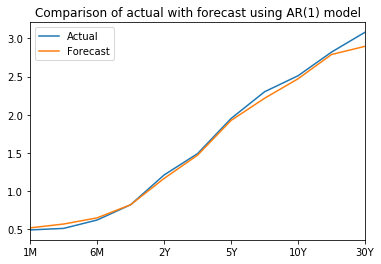

/Users/Hatim/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:133: FutureWarning: sort(....) is deprecated, use sort_index(.....)


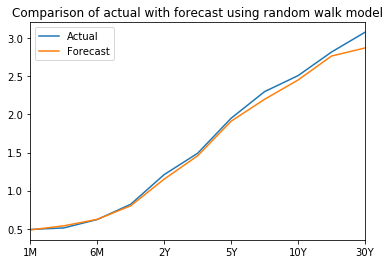

In [21]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.stats.plm import PanelOLS 
import statsmodels.tsa.arima_model
from math import sqrt
from sklearn.metrics import mean_squared_error

file = "/Users/Hatim/Desktop/CMT-all.xlsx"

#Data Import
data = pd.read_excel(file, index_col = 0)
data2 = data.ix['2017-01-16':'2017-01-26',:]
data2 = data2.stack()
data.index.name = None
data=data.ix['2007-01-01':'2017-01-15',:]

level_data=data

#interpolating the missing data
level_data.interpolate(method='linear',order = 2, axis =  1, inplace=True)

#dropping the NAs if any
data=data.dropna(how='all')


f1=np.array([1/12,3/12,6/12,1,2,3,5,7,10,20,30],dtype=np.float64) 
 
max_rsquare=0
min_lambda=0
for i in np.arange(0.3,0.7,0.01):
    lam=i
    level_data_stack=pd.DataFrame(level_data.stack())
    k2= (1-np.exp(-lam*f1))/(lam*f1)
    k3= (1-np.exp(-lam*f1))/(lam*f1)-(np.exp(-lam*f1))
    z=np.zeros((11,2))
    z[:,0] = k2
    z[:,1] = k3
    df_fixed=pd.DataFrame(np.tile(z,(data.shape[0],1)))
    
    ##Doing the panel OLS##
    
    #setting the same index so that we can concat the two dataframes
    df_fixed.index=level_data_stack.index
    concat_df=pd.concat((level_data_stack,df_fixed),axis=1)
    concat_df.columns=['yield','k2','k3']
    mymod= PanelOLS(y=concat_df['yield'],x=concat_df[['k2','k3']],time_effects=True)
    if(max_rsquare<mymod.r2):
        max_rsquare=mymod.r2
        min_lambda=lam
opt_lam=min_lambda

print("-----The optimal value of lambda and the corresponding r-square is-----")
print(minlam,max_rsquare)
 
beta_timeseries=[]
beta_df=pd.DataFrame()

#getting the daily betas
for j in np.arange(0,concat_df.shape[0],11):
    concat_df['intercept']=np.ones(concat_df.shape[0])
    modelyc= sm.OLS(concat_df.ix[j:j+11,'yield'],concat_df.ix[j:j+11,['k2','k3','intercept']]).fit()
    lst=[modelyc.params[2],modelyc.params[0],modelyc.params[1]]
    beta_timeseries.append(lst)
    beta_df=pd.DataFrame(beta_timeseries)


beta_df.index = data.index
beta_df2 = beta_df.append([beta_df]*10)
beta_df2 = beta_df2.sort(ascending=True)
beta_df2.index = concat_df.index
concat_df = pd.concat((concat_df,beta_df2),axis=1)
concat_df['y_hat'] = concat_df['intercept']*concat_df[0] + concat_df['k2']*concat_df[1] + concat_df['k3']*concat_df[2]
sample = concat_df.ix[0:88,'k2':'intercept']
sample = sample.reset_index()
sample = sample.ix[0:88,'k2':'intercept']
sample.index = data2.index
data2=pd.concat((data2,sample),axis=1)
data3 = data2

rmse = []
for j in np.arange(0,concat_df.shape[0],11):
    rms = sqrt(mean_squared_error(concat_df.ix[j:j+11,'yield'],concat_df.ix[j:j+11,'y_hat']))
    rmse.append(rms)
    

rmse = pd.DataFrame(rmse)
rmse.index = data.index
rmse = rmse.sort(0,ascending=False)
print("-----5 days with the largest RMSE-----")
print(rmse.head(5))


beta_df.index=data.index
#Fitting AR(1) to three betas
arima1 = statsmodels.tsa.arima_model.ARIMA(beta_df[0],(1,0,0)).fit()
arima2 = statsmodels.tsa.arima_model.ARIMA(beta_df[1],(1,0,0)).fit()
arima3 = statsmodels.tsa.arima_model.ARIMA(beta_df[2],(1,0,0)).fit()

#forecasting using arima model
for1 = arima1.forecast(8)[0]
for2 = arima2.forecast(8)[0]
for3 = arima3.forecast(8)[0]
forecast = {'beta1':for1, 'beta2':for2,'beta3':for3}
forecast = pd.DataFrame(forecast)
forecast2 = forecast
forecast2 = forecast2.append([forecast]*10)
forecast2 = forecast2.sort(ascending='True')
forecast2.index = data2.index
data2 = pd.concat((data2,forecast2),axis=1)
#getting the forecasted value for yield
data2['forecast'] = data2['intercept']*data2['beta1'] + data2['k2']*data2['beta2'] + data2['k3']*data2['beta3']
data2.ix['2017-01-26',0].plot(label='Actual');data2.ix['2017-01-26','forecast'].plot(label='Forecast')
plt.legend(loc='upper left')
plt.title("Comparison of actual with forecast using AR(1) model")
plt.show()


#using the random walk model
arima1_random = statsmodels.tsa.arima_model.ARIMA(np.array(beta_df[0]),(0,1,0)).fit()
arima2_random = statsmodels.tsa.arima_model.ARIMA(np.array(beta_df[1]),(0,1,0)).fit()
arima3_random = statsmodels.tsa.arima_model.ARIMA(np.array(beta_df[2]),(0,1,0)).fit()

#forecasting the betas using random walk model
for1_random = arima1_random.forecast(8)[0]
for2_random = arima2_random.forecast(8)[0]
for3_random = arima3_random.forecast(8)[0]
forecast_random = {'beta1':for1_random, 'beta2':for2_random,'beta3':for3_random}
forecast_random = pd.DataFrame(forecast_random)
forecast2_random = forecast_random
forecast2_random = forecast2_random.append([forecast_random]*10)
forecast2_random = forecast2_random.sort(ascending='True')
forecast2_random.index = data3.index
data3 = pd.concat((data3,forecast2_random),axis=1)

#getting the forecasted value for yield using random walk model
data3['forecast'] = data3['intercept']*data3['beta1'] + data3['k2']*data3['beta2'] + data3['k3']*data3['beta3']
data3.ix['2017-01-26',0].plot(label='Actual');data3.ix['2017-01-26','forecast'].plot(label='Forecast')
plt.legend(loc='upper left')
plt.title("Comparison of actual with forecast using random walk model")
plt.show()